In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Berlin data: Airbnb & inhabitants per district in 2017

In [2]:
# Load airbnb berlin historical data
link_location_airbnb_data = "http://insideairbnb.com/get-the-data.html"
airbnb_listings = pd.read_csv('./data/listings_airbnb_berlin.csv')
airbnb_reviews = pd.read_csv('./data/reviews_airbnb_berlin.csv')

# Assign reviews to each listing
airbnb = airbnb_listings.merge(airbnb_reviews, left_on='id', right_on='listing_id').rename(columns={'date':'date_review'})

# Load population of berlin data for 2017
n_inhabitants = pd.read_csv('./data/inhabitants_berlin_17.csv',sep='\t')
n_inhabitants['n_inhabitants'] = n_inhabitants['n_inhabitants'].astype(int)

In [3]:
n_inhabitants

,district,n_inhabitants
0,Mitte,373944
1,Friedrichshain-Kreuzberg,281860
2,Pankow,398732
3,Charlottenburg-Wilm.,338405
4,Spandau,240998
5,Steglitz - Zehlendorf,305430
6,Tempelhof - Schöneberg,347927
7,Neukölln,328659
8,Treptow - Köpenick,262543
9,Marzahn - Hellersdorf,264461


### Calculate Airbnb KPIs

In [3]:
# Transform Airbnb reviews/listings for visualizations
# Extract years of host registration, listing first review and each review
airbnb['date_review_year'] = pd.to_datetime(airbnb['date_review']).dt.year
airbnb['date_review_year'] = airbnb['date_review_year'].fillna(0).astype(int)

airbnb['first_review_year'] = pd.to_datetime(airbnb['first_review']).dt.year
airbnb['first_review_year'] = airbnb['first_review_year'].fillna(0).astype(int)

airbnb['host_since_year'] = pd.to_datetime(airbnb['host_since']).dt.year
airbnb['host_since_year'] = airbnb['host_since_year'].fillna(0).astype(int)

# Calculate dataframe with one record per unique listing
n_listings = airbnb.groupby(['id'], as_index=False).first().rename(columns={'id':'listing_id'})

# Calculate dataframe with one record per unique host
n_hosts = n_listings.groupby(['host_id'], as_index=False).first()

# Calculate number of listings per year of first review and type of room
n_listings_room_type = n_listings.groupby(['first_review_year','room_type'], as_index=False).count()
n_listings_room_type = n_listings_room_type.loc[:,("first_review_year","host_id","room_type")]

# Definition of host type
# if 1 listing and shared -> sharing airbnb
# if 1 listing and entire appartment -> complete flat airbnb
# if > 1 listing -> business airbnb
user_type_identifier = n_listings.loc[:,('host_id','host_total_listings_count','first_review_year','room_type')]
user_type_identifier['host_type'] = 'share_airbnb'
user_type_identifier.loc[user_type_identifier['host_total_listings_count'] > 1,'host_type'] = 'business_airbnb'
user_type_identifier.loc[(user_type_identifier['host_total_listings_count'] == 1) &\
                         (user_type_identifier['room_type'] == 'Entire home/apt'),'host_type'] = 'flat_airbnb'
user_type_identifier = user_type_identifier[user_type_identifier['first_review_year'] != 0]
n_list_type_evol = user_type_identifier.copy()
user_type_identifier = user_type_identifier.loc[:,('host_id','host_type')].drop_duplicates()

# build data sets of number of listings per year of listing first review per host type
n_list_type_evol_ = n_list_type_evol.groupby(['first_review_year','host_type'], as_index=False).count()

# build data sets of number of reviews per year of listing first review per host type
n_revs_type_evol = airbnb.loc[:,('listing_id','host_id','date_review_year')].merge(user_type_identifier, 
                                                                                  left_on='host_id', 
                                                                                  right_on='host_id')
n_revs_type_evol_ = n_revs_type_evol.groupby(['date_review_year','host_type'], as_index=False).count()

# save data
n_revs_type_evol_ = n_revs_type_evol_.loc[:,('date_review_year','host_type',
                                             'listing_id')].rename(columns={'listing_id':'n_reviews'})
n_revs_type_evol_.to_csv('./data/n_reviews_year_host_type_berlin.csv', index=False, encoding='utf-8')

n_list_type_evol.to_csv('./data/n_listings_year_host_type_room_type_berlin.csv', index=False, encoding='utf-8')

In [4]:
# Calculate number of listings per district per 1000 inhabitants
n_list_inhab = airbnb[(airbnb['date_review_year']==2017) & \
                       ~(airbnb['neighbourhood_group_cleansed'].isnull())]
n_list_inhab = n_list_inhab.loc[:,('listing_id','neighbourhood_group_cleansed','date_review_year')]
n_list_inhab = n_list_inhab.groupby(['listing_id'], as_index=False).first().groupby(['neighbourhood_group_cleansed'], 
                                                                     as_index=False).count()

# Calculate the ratio of listings per 1000 inhabitants per district
n_list_inhab_ = n_list_inhab.merge(n_inhabitants, left_on='neighbourhood_group_cleansed', right_on='district')
n_list_inhab_['n_list_inh_1000'] = n_list_inhab_['listing_id']/n_list_inhab_['n_inhabitants']*1000
n_list_inhab_ = n_list_inhab_.loc[:,('district','listing_id','n_inhabitants','n_list_inh_1000')]

# save data
n_list_inhab_.to_csv('./data/n_airbnb_listings_1000_inhab_district_berlin.csv', index=False, encoding='utf-8')

### Quickly visualize Airbnb KPIs

In [5]:
n_list_inhab_

,district,listing_id,n_inhabitants,n_list_inh_1000
0,Charlottenburg-Wilm.,707,338405,2.089213
1,Friedrichshain-Kreuzberg,2385,281860,8.461648
2,Lichtenberg,261,283334,0.921174
3,Marzahn - Hellersdorf,45,264461,0.170157
4,Mitte,2094,373944,5.599769
5,Neukölln,1376,328659,4.186710
6,Pankow,1598,398732,4.007704
7,Reinickendorf,99,262683,0.376880
8,Spandau,45,240998,0.186724
9,Steglitz - Zehlendorf,171,305430,0.559866


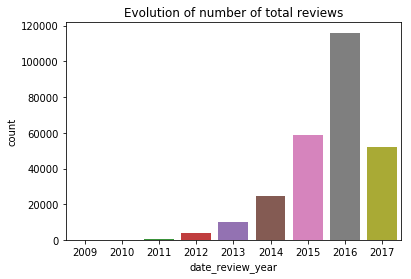

In [14]:
sns.countplot(airbnb.date_review_year)
plt.title("Evolution of number of total reviews")

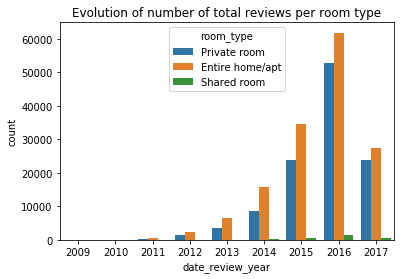

In [15]:
sns.countplot(x="date_review_year",hue="room_type",data=airbnb)
plt.title("Evolution of number of total reviews per room type")

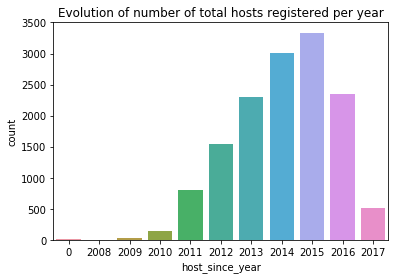

In [16]:
# number of host registered per year
sns.countplot(n_hosts.host_since_year)
plt.title("Evolution of number of total hosts registered per year")

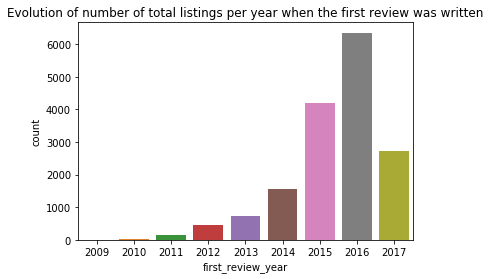

In [17]:
# number of listings per year that the listing was registered
sns.countplot(n_listings.first_review_year)
plt.title("Evolution of number of total listings per year when the first review was written")

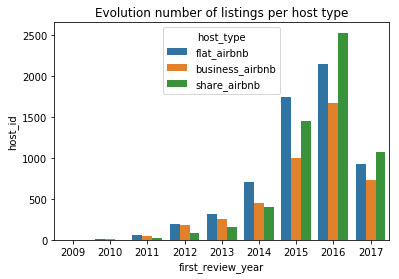

In [23]:
sns.barplot(x='first_review_year', y='host_id',hue='host_type',data=n_list_type_evol_)
plt.title("Evolution number of listings per host type")

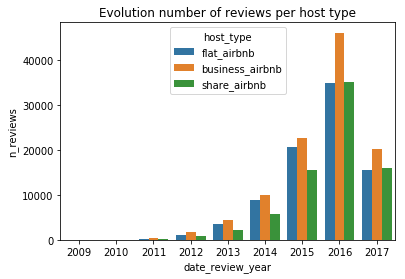

In [20]:
sns.barplot(x='date_review_year', y='n_reviews',hue='host_type',data=n_revs_type_evol_)
plt.title("Evolution number of reviews per host type")